<a href="https://colab.research.google.com/github/yanjinli1993/GMMDA/blob/main/zaima_classbase_NOLAXL_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initializations

In [1]:
#@title Install the required libs
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate transformers safetensors ftfy invisible-watermark>=2.0
!pip install -qq "ipywidgets>=7,<8"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.4 MB/s eta 0:00:00


In [2]:
#@title [Optional] Install xformers for faster and memory efficient training
#@markdown Acknowledgement: The xformers wheel are taken from [TheLastBen/fast-stable-diffusion](https://github.com/TheLastBen/fast-stable-diffusion). Thanks a lot for building these wheels!
%%time

!pip install -U --pre triton

from subprocess import getoutput
from IPython.display import HTML
from IPython.display import clear_output
import time

s = getoutput('nvidia-smi')
if 'T4' in s:
  gpu = 'T4'
elif 'P100' in s:
  gpu = 'P100'
elif 'V100' in s:
  gpu = 'V100'
elif 'A100' in s:
  gpu = 'A100'

while True:
    try:
        gpu=='T4'or gpu=='P100'or gpu=='V100'or gpu=='A100'
        break
    except:
        pass
    print('[1;31mit seems that your GPU is not supported at the moment')
    time.sleep(5)

if (gpu=='T4'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='P100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/P100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='V100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/V100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='A100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 26.5 MB/s eta 0:00:00
  ERROR: HTTP error 404 while getting https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl
ERROR: Could not install requirement xformers==0.0.13.dev0 from https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl because of HTTP error 404 Client Error: Not Found for url: https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl for URL https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl
CPU times: user 46.7 ms, sys: 6.11 ms, total: 52.8 ms
Wall time: 6.47 s


In [3]:
#@title Install the required libs
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate transformers ftfy fire safetensors
!pip install -qq "ipywidgets>=7,<8"

#@title Import LoRA required libraries
!git clone https://github.com/cloneofsimo/lora.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Cloning into 'lora'...
remote: Enumerating objects: 934, done.
remote: Counting objects: 100% (418/418), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 934 (delta 356), reused 307 (delta 307), pack-reused 516
Receiving objects: 100% (934/934), 182.96 MiB | 16.46 MiB/s, done.
Resolving deltas: 100% (561/561), done.


In [4]:
"""#Import LoRA required libraries
!git clone https://github.com/cloneofsimo/lora.git"""

'#Import LoRA required libraries\n!git clone https://github.com/cloneofsimo/lora.git'

# NOLA Inference Class

In [5]:
import sys
sys.path.append('lora')

import argparse
import itertools
import math
import os
import random
import gc

import inspect
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

from pathlib import Path
import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel, DPMSolverMultistepScheduler
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from lora_diffusion import (
    extract_lora_ups_down,
    inject_trainable_lora,
    safetensors_available,
    save_lora_weight,
    save_safeloras,
)
from lora_diffusion.xformers_utils import set_use_memory_efficient_attention_xformers

import torch
from lora_diffusion import monkeypatch_or_replace_lora, tune_lora_scale
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionSAGPipeline
import pandas as pd

class NolaInference:
  """
  This is the inference class for NOLA v1.2
  Stable Diffusion V2.1
  """
  def __init__(self,
               product_type,
               brand_name,
               product_name,
               token_emb_version="",
               dir_owner="Linchuan",
               version="SDV2_1_NOLA"):
    self.product_type = product_type
    self.brand_name = brand_name
    self.product_name = product_name
    self.token_emb_version = token_emb_version
    self.dir_owner = dir_owner
    self.version = version


  def mount_gdrive(self, save_to_gdrive=True):
    if save_to_gdrive:
        from google.colab import drive
        drive.mount('/content/drive')

    #Enter the directory name to save model at.
    self.OUTPUT_DIR = f"{self.dir_owner}/stable_diffusion_weights/{self.version}/{self.brand_name}/{self.product_type}"

    if save_to_gdrive:
        self.OUTPUT_DIR = "/content/drive/Shareddrives/TheSEA_tech/" + self.OUTPUT_DIR
    else:
        self.OUTPUT_DIR = "/content/" + self.OUTPUT_DIR

    print(f"[*] Weights will be saved at {self.OUTPUT_DIR}")
    OUTPUT_DIR = self.OUTPUT_DIR
    !mkdir -p $OUTPUT_DIR

    self.embedding_dir = self.OUTPUT_DIR + f"/optimize_token_embeddings{self.token_emb_version}"

    self.revision = None

  def load_lora_pipelines(self, model_name, pipe_type, dtype):

    if dtype == 16:
      torch_dtype = torch.float16
    else:
      torch_dtype = torch.float32

    if pipe_type == 'default':
      pipe = StableDiffusionPipeline.from_pretrained(
          self.embedding_dir,
          torch_dtype=torch_dtype).to("cuda")

    elif pipe_type == 'sag':
      pipe = StableDiffusionSAGPipeline.from_pretrained(
          self.embedding_dir,
          torch_dtype=torch_dtype).to("cuda")

    parameter_dir = self.OUTPUT_DIR+ f"/{model_name}"

    monkeypatch_or_replace_lora(
        pipe.unet,
        torch.load(os.path.join(parameter_dir, "lora_weight.pt")))

    monkeypatch_or_replace_lora(
        pipe.text_encoder,
        torch.load(os.path.join(parameter_dir, "lora_weight.text_encoder.pt")),
        target_replace_module=["CLIPAttention"])

    pipe.safety_checker = None
    pipe = pipe.to("cuda")

    return(pipe)


  def _make_save_dir(self, model_name):
    self.prefix_saving_dir = self.OUTPUT_DIR + "/output/"
    saving_dir = self.prefix_saving_dir + f"{model_name}"

    print(f"[*] Data will be saved at {saving_dir}")
    !mkdir -p $saving_dir


  def load_all_pipes(self, pipe_names, pipe_type='default', dtype=16):
    self.pipe_names = pipe_names
    self.pipe_type = pipe_type
    self.dtype = dtype

    self.dict_pipes = {}

    for name in self.pipe_names:
      self.dict_pipes[f'{name}'] = self.load_lora_pipelines(
          model_name=name,
          pipe_type=self.pipe_type,
          dtype=self.dtype)

      self._make_save_dir(name)

    return(self.dict_pipes)


  def test_inference(self,
                     test_prompt,
                     test_pipe,
                     num_rows=3,
                     num_samples=3,
                     lora_scale_unet=1,
                     lora_scale_text_encoder=1,
                     guidance=5,
                     inference_step=50,
                     test_negative_prompt="ugly, poor composition, 3d rendering",
                     ):

    tune_lora_scale(test_pipe.unet, lora_scale_unet)

    print('prompt:', test_prompt)
    with torch.inference_mode():
      all_images = []
      for _ in range(num_rows):
          images = test_pipe([test_prompt] * num_samples,
                        negative_prompt = [test_negative_prompt] * num_samples,
                        num_inference_steps=inference_step,
                        guidance_scale=guidance).images
          all_images.extend(images)

    grid = self.image_grid(all_images, num_rows, num_samples)
    return(grid)

  def run_inference(self,
                    #prompt,
                    inference_steps,
                    guidances,
                    pipes,
                    sub_directory_name,
                    bg_list,
                    num_samples=1,
                    num_rows=1,
                    total_samples=100,
                    lora_scale_unet=1,
                    lora_scale_text_encoder=1,
                    sag_scale=0.1,
                    prefix="product shot of ",
                    negative_prompt="text, ugly, poor composition, 3d rendering",):

    for i in range(len(pipes)):
      pipe_name = self.pipe_names[i]
      pipe = pipes[pipe_name]
      tune_lora_scale(pipe.unet, lora_scale_unet)
      tune_lora_scale(pipe.text_encoder, lora_scale_text_encoder)##additional codes

      temp_saving_dir = self.prefix_saving_dir + f"{pipe_name}/{sub_directory_name}"

      print(f"[*] Images will be saved at {temp_saving_dir}")
      !mkdir -p $temp_saving_dir

      file_endswith = '.jpg'
      image_paths = [os.path.join(temp_saving_dir, file_path)
                      for file_path in os.listdir(temp_saving_dir)
                      if file_path.endswith(file_endswith)]
      max_index = len(image_paths)

      if max_index == 0:
        d = {'image_index': [],
          'prompt': [],
          'negative_prompt': [],
          'guidance_scale' : [],
          'inference_step': [],
          'finetune_step': []
          }
        df = pd.DataFrame(data=d)
        df.to_csv(temp_saving_dir+'/img_index.csv', index=False)
      else:
        df = pd.read_csv(temp_saving_dir +'/img_index.csv')

      print(f"pipe type:{self.pipe_type}")
      for bg in bg_list: #{product_type} materials, painting, drawing,
        for guidance in guidances:
          for inference_step in inference_steps:
            for _ in range(total_samples):

              prompt = f"""{prefix} a {self.product_name} {bg}"""
              print('prompt:', prompt)
              with torch.inference_mode():
                all_images = []
                for _ in range(num_rows):
                  if self.pipe_type == 'sag':
                    images = pipe([prompt] * num_samples,
                                  negative_prompt = [negative_prompt] * num_samples,
                                  num_inference_steps=inference_step,
                                  guidance_scale=guidance,
                                  sag_scale=sag_scale).images
                    all_images.extend(images)
                  else:
                    images = pipe([prompt] * num_samples,
                                  negative_prompt = [negative_prompt] * num_samples,
                                  num_inference_steps=inference_step,
                                  guidance_scale=guidance).images
                    all_images.extend(images)

              grid = self.image_grid(all_images, num_rows, num_samples)

              grid.save(temp_saving_dir+f'/id={max_index}_pipe={pipe_name}_if={inference_step}_gs={guidance}.jpg')

              new_row = {'image_index': max_index,
                  'prompt': prompt,
                  'negative_prompt': negative_prompt,
                  'guidance_scale' : guidance,
                  'inference_step': inference_step,
                  'pipe_name': pipe_name,
                  }
              df = df.append(new_row, ignore_index=True)

              max_index = max_index + 1



      df.to_csv(temp_saving_dir+'/img_index.csv', index=False)

  # additional tools
  def image_grid(self, imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


# Inference

In [12]:
product_type = 'Smoker'
brand_name = f'Zaima'
product_name = "cookingpot=zaima cooking pot"
token_emb_version = ""

pipe_names = [f"lora_1500{token_emb_version}"] #{token_emb_version}

nola = NolaInference(
    product_type,
    brand_name,
    product_name,
    token_emb_version
)

nola.mount_gdrive()
#dict_pipes_sag = nola.load_all_pipes(pipe_names, pipe_type='sag', dtype=32)
dict_pipes_default = nola.load_all_pipes(pipe_names, pipe_type='default', dtype=16)

Mounted at /content/drive
[*] Weights will be saved at /content/drive/Shareddrives/TheSEA_tech/Linchuan/stable_diffusion_weights/SDXL_NOLA/Zaima/Smoker


The config attributes {'force_zeros_for_empty_prompt': True, 'text_encoder_2': ['transformers', 'CLIPTextModelWithProjection'], 'tokenizer_2': ['transformers', 'CLIPTokenizer']} were passed to StableDiffusionPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'force_zeros_for_empty_prompt': True, 'text_encoder_2': ['transformers', 'CLIPTextModelWithProjection'], 'tokenizer_2': ['transformers', 'CLIPTokenizer']} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 17>:17                                                                            │
│ in load_all_pipes:138                                                                            │
│ in load_lora_pipelines:109                                                                       │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/serialization.py:791 in load                       │
│                                                                                                  │
│    788 │   if 'encoding' not in pickle_load_args.keys():                                         │
│    789 │   │   pickle_load_args['encoding'] = 'utf-8'                                            │
│    790 │                                                                                         │
│ ❱  791 │   with _open_file_like(f, 'rb') as opened_file:                                         │
│    792 │   │   if _is_zipfile(opened_file):                                                      │
│    793 │   │   │   # The zipfile reader is going to advance the current file position.           │
│    794 │   │   │   # If we want to actually tail call to torch.jit.load, we need to              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/serialization.py:271 in _open_file_like            │
│                                                                                                  │
│    268                                                                                           │
│    269 def _open_file_like(name_or_buffer, mode):                                                │
│    270 │   if _is_path(name_or_buffer):                                                          │
│ ❱  271 │   │   return _open_file(name_or_buffer, mode)                                           │
│    272 │   else:                                                                                 │
│    273 │   │   if 'w' in mode:                                                                   │
│    274 │   │   │   return _open_buffer_writer(name_or_buffer)                                    │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/serialization.py:252 in __init__                   │
│                                                                                                  │
│    249                                                                                           │
│    250 class _open_file(_opener):                                                                │
│    251 │   def __init__(self, name, mode):                                                       │
│ ❱  252 │   │   super().__init__(open(name, mode))                                                │
│    253 │                                                                                         │
│    254 │   def __exit__(self, *args):                                                            │
│    255 │   │   self.file_like.close()                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
FileNotFoundError: [Errno 2] No such file or directory: 
'/content/drive/Shareddrives/TheSEA_tech/Linchuan/stable_diffusion_weights/SDXL_NOLA/Zaima/Smoker/lora_1500/lora_we
ight.pt'

In [ ]:
#@title Testing Inference
GUIDANCE=5
INFERENCE_STEP=50

TEST_PROMPT = f"""product shot of a {product_name} sitting in an apartment, official promotional photo""" #shallow focus of field,

grid = nola.test_inference(
    TEST_PROMPT,
    test_pipe=list(dict_pipes_default.values())[0],
    num_rows=3,
    guidance=GUIDANCE,
    inference_step=INFERENCE_STEP
    )
grid

In [ ]:
grid

In [ ]:
#@title Production Inference
GUIDANCES = [5]
INFERENCE_STEPS = [50]

BACKGROUNDS = [
    "sitting on a dinning table in front of a Japanese garden, a small plate of cheese cubes and red wine, shallow focus of field, soft lighting",
    #"sitting on a dinning table in front of a Japanese garden, a small plate of cheese cubes and sausage, shallow focus of field, soft lighting",
    #"sitting on a dinning table in front of a garden, a small plate of cheese cubes and sausage, shallow focus of field, soft lighting",
    "sitting on a dinning table in front of a garden, a small plate of cheese cubes, shallow focus of field, soft lighting",
    "sitting next to a small plate of cheese cubes on a dinning table in front of a garden, soft lighting, shallow focus of field",
    "sitting next to a small plate of cheese cubes on a dinning table in front of a Japanese garden, soft lighting, shallow focus of field",
    "sitting next to a small plate of cheese cubes and sausage on a dinning table, soft lighting",
    "sitting on a dinning table, a small plate of cheese cubes and sausage, soft lighting",

    #"sitting in an apartment, enhanced details",
    #"sitting in campground, enhanced details",
    #"sitting next to a tent in a campground, enhanced details",
    #"sitting next to a tent in a campground, shallow focus of field, enhanced details",
]

nola.run_inference(
    inference_steps=INFERENCE_STEPS,
    pipes=dict_pipes_default,
    guidances=GUIDANCES,
    bg_list=BACKGROUNDS,
    prefix="a photo of",
    total_samples=300,
    sub_directory_name='p1')


"""nola.run_inference(
    inference_steps=INFERENCE_STEPS,
    pipes=dict_pipes_default,
    guidances=GUIDANCES,
    bg_list=BACKGROUNDS,
    prefix="product shot of",
    total_samples=300,
    sub_directory_name='p2')"""


"""nola.run_inference(
    inference_steps=INFERENCE_STEPS,
    pipes=dict_pipes_default,
    guidances=GUIDANCES,
    bg_list=BACKGROUNDS,
    prefix="there is",
    total_samples=500)"""


In [5]:
import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    UNet2DConditionModel,
    StableDiffusionXLPipeline,
)
from diffusers.loaders import LoraLoaderMixin
from diffusers.models.attention_processor import LoRAAttnProcessor, LoRAAttnProcessor2_0
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available


In [9]:
from google.colab import drive
import torch

save_to_gdrive = True #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

output_dir = f"Linchuan/stable_diffusion_weights/SDXL_NOLA/Zaima/Smoker/"

output_dir = "/content/drive/Shareddrives/TheSEA_tech/" + output_dir

embedding_dir = "optimize_token_embeddings"

model_path = output_dir + embedding_dir
print('model path:',model_path)
pipeline = StableDiffusionXLPipeline.from_pretrained(
    model_path, revision=None, torch_dtype=torch.float16
)

# We train on the simplified learning objective. If we were previously predicting a variance, we need the scheduler to ignore it
scheduler_args = {}

if "variance_type" in pipeline.scheduler.config:
    variance_type = pipeline.scheduler.config.variance_type

    if variance_type in ["learned", "learned_range"]:
        variance_type = "fixed_small"

    scheduler_args["variance_type"] = variance_type

pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config, **scheduler_args)

pipeline = pipeline.to("cuda")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
model path: /content/drive/Shareddrives/TheSEA_tech/Linchuan/stable_diffusion_weights/SDXL_NOLA/Zaima/Smoker/optimize_token_embeddings


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
#@title load attention processors
output_folder = "/lora_1500"
lora_path = output_dir + output_folder
print(f'lora_path = {lora_path}')
pipeline.load_lora_weights(lora_path)

lora_path = /content/drive/Shareddrives/TheSEA_tech/Linchuan/stable_diffusion_weights/SDXL_NOLA/Zaima/Smoker//lora_1500


In [17]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

INFERENCE_PROMPT = product shot of a cookingpot=zaima cooking pot


  0%|          | 0/25 [00:00<?, ?it/s]

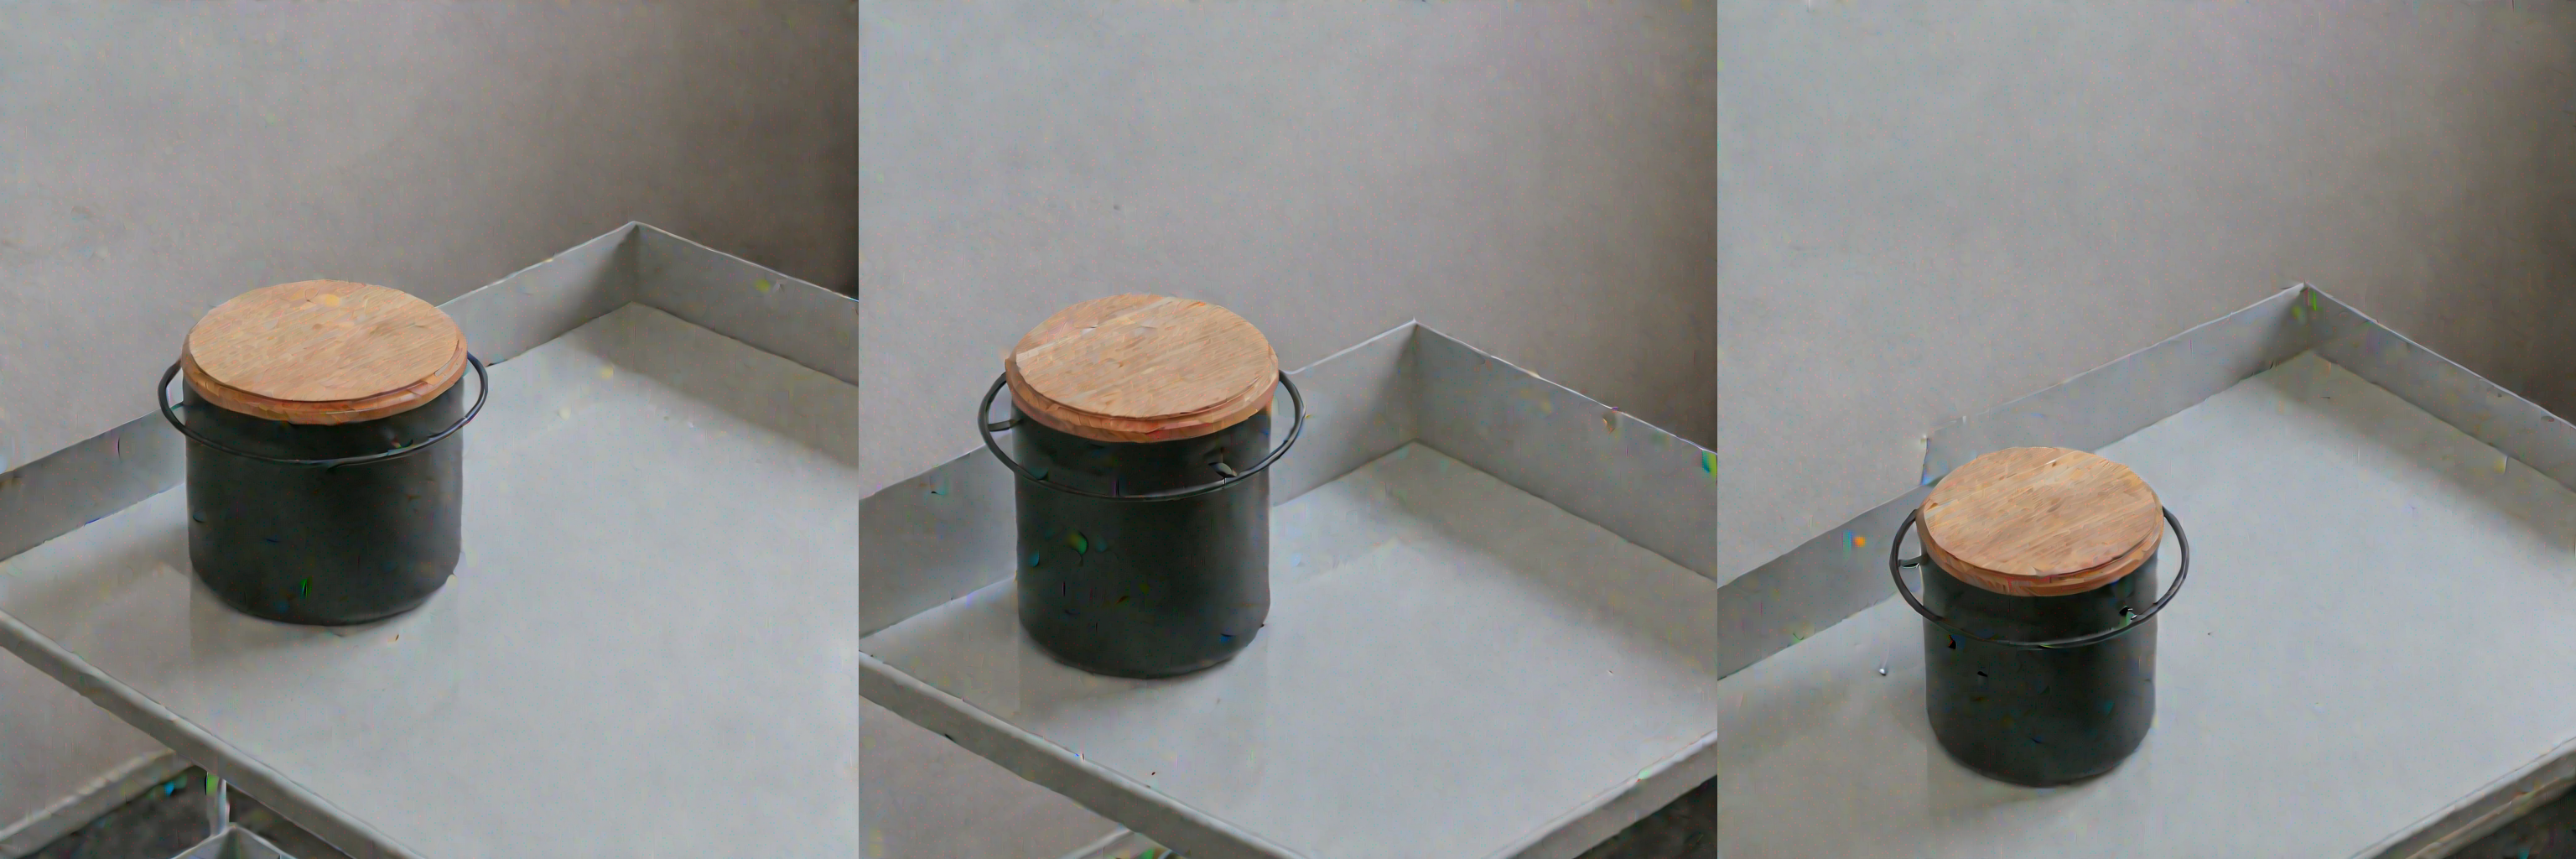

In [18]:
#@title  run inference

INFERENCE_PROMPT = "product shot of a cookingpot=zaima cooking pot"
print(f'INFERENCE_PROMPT = {INFERENCE_PROMPT}')
GUIDANCE = 2.5
num_rows = 1
rows = 1
cols = 3

seed=1024
generator = torch.Generator(device='cuda').manual_seed(seed) if seed else None
image = pipeline(INFERENCE_PROMPT,
                 num_images_per_prompt=3,
                 num_inference_steps=25,
                 guidance_scale=GUIDANCE,
                 generator=generator).images


image_grid(image,rows=rows,cols=cols)


In [ ]:
INFERENCE_PROMPT = "a photo of a cookingpot=zaima cooking pot"
print(f'INFERENCE_PROMPT = {INFERENCE_PROMPT}')
GUIDANCE = 2.5
num_rows = 1
rows = 1
cols = 3

seed=1024
generator = torch.Generator(device='cuda').manual_seed(seed) if seed else None
image = pipeline(INFERENCE_PROMPT,
                 num_images_per_prompt=3,
                 num_inference_steps=25,
                 guidance_scale=GUIDANCE,
                 generator=generator).images


image_grid(image,rows=rows,cols=cols)